In [1]:
%pip install --user pandas scipy numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import time
import numpy as np
from scipy.stats import chisquare
import collections
import math
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import gamma
from scipy.stats import chi2
from scipy.stats import kstest
from scipy.stats import rankdata
import random
import glob
import bz2
import os

#### Data preparation 

In [3]:
# Extract the leading digit from a string, considering possible decimal points
def get_leading_digit(s):
    # Strip leading zeros
    s = s.lstrip('0')
    
    # If the first character is a decimal point, find the first non-zero digit after it
    if s and s[0] == '.':
        s = s[1:].lstrip('0')
    
    # Return the first non-zero digit, or 0 if no such digit is found
    return int(s[0]) if s else 0


# Define a function to convert a string to a number
def convert_to_number(s):
    try:
        return float(s)
    except ValueError:
        return None

# List to store numbers extracted from the dataset
numbers = []

# Retrieve all .trans files, change if needed
filenames = glob.glob('/mnt/data/exomol/exomol3_data/TiO/49Ti-16O/Toto/*.trans.bz2')
filenames = sorted(filenames)

# ## For sample input
# # get current repository
# current_directory = os.getcwd()
# filenames = glob.glob(os.path.join(current_directory, '*.trans.bz2'))

# Process each file in the directory
for filename in filenames:
    # Open the file
    with bz2.open(filename, 'r') as file:

        # loop over the lines in the file
        for line in file:
    
            # Split the line on spaces (or appropriate delimiter)
            data = line.strip().split()
            
            # Convert the third column to a number and add it to the list
            number = convert_to_number(data[2])
            if number is not None:
                numbers.append(number)


# Convert the list of numbers to a pandas Series and display basic statistics
numbers_series = pd.Series(numbers)
print(numbers_series.describe())

count    5.932453e+07
mean     2.071806e+04
std      1.828748e+05
min      2.281900e-71
25%      4.187700e-11
50%      9.261400e-06
75%      7.055600e-01
max      2.351900e+07
dtype: float64


#### Transform Dataset

In [4]:
# Transform the original dataset to a new one using fixed intervals based on the range of logarithms

# Compute the logarithms
log_data = np.log10(numbers_series)

# Determine the boundaries for fixed intervals based on the range of logarithms
interval_count = 3  # the number of intervals that divide the dataset into, change if needed
interval_size = (log_data.max() - log_data.min()) / interval_count
boundaries = [log_data.min() + i * interval_size for i in range(interval_count + 1)]

# Initialize an empty list to store the transformed data
transformed_numbers = []

for i in range(len(boundaries) - 1):
    # Extract data points within the current interval, including both boundaries
    mask = (log_data >= boundaries[i]) & (log_data <= boundaries[i+1])
    subset = log_data[mask]
    
    # Rank the logarithms within this interval
    ranks = rankdata(subset)
    
    # Assign uniform quantiles and map to uniform distribution within the interval
    uniform_logs = (ranks - 1) / len(subset) * (boundaries[i+1] - boundaries[i]) + boundaries[i]
    
    # Convert back to numbers and append to the transformed data list
    transformed_numbers.extend(10**uniform_logs)

# Display statistics for the transformed dataset
transformed_numbers_series = pd.Series(transformed_numbers)
print(transformed_numbers_series.describe())

count    5.932453e+07
mean     3.802574e+05
std      2.080153e+06
min      2.281900e-71
25%      1.680829e-13
50%      8.726089e-07
75%      4.530241e+00
max      2.351896e+07
dtype: float64


In [5]:
# Extract the leading digit from the transformed dataset
leading_digits_transformed = [get_leading_digit(str(num)) for num in transformed_numbers]

# Count the frequency of each leading digit in the transformed dataset
leading_digit_counts_transformed = collections.Counter(leading_digits_transformed)

total_count = sum(leading_digit_counts_transformed.values())
observed_frequencies = dict(sorted(leading_digit_counts_transformed.items()))

# Print the frequencies
print(observed_frequencies)

{1: 17855273, 2: 10454800, 3: 7410616, 4: 5748303, 5: 4696437, 6: 3971000, 7: 3439654, 8: 3034151, 9: 2714296}


#### Plot visulisation for transformed dataset on a log scale

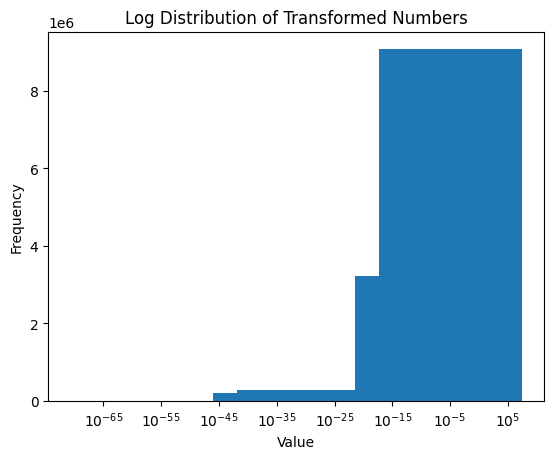

In [6]:
# Visualization of the distribution on a logarithmic scale
plt.hist(transformed_numbers, bins=np.logspace(np.log10(min(transformed_numbers)), np.log10(max(transformed_numbers)), 20))
plt.xscale('log')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Log Distribution of Transformed Numbers')
plt.show()

#### Chi-square test

In [7]:
# Calculate the expected frequency for each leading digit under the assumption of Benford's Law
expected_frequencies_ben = {i: total_count * math.log10(1 + 1/i) for i in range(1, 10)}

# As the function shows above, calculate chi_squate statistic
def chi_square_statistic(observed, expected):
    return sum([(o - e)**2 / e for o, e in zip(observed, expected)])

# Use the custom chi-square statistic function
chi2_stat_ben = chi_square_statistic(list(observed_frequencies.values()), list(expected_frequencies_ben.values()))

# Print chi-square values
print("Chi-square statistic for Benford's Law:", chi2_stat_ben)

# Chi-square PDF
def chi2_pdf(x, df):
    return (1 / (2 ** (df / 2) * gamma(df / 2))) * x ** (df / 2 - 1) * np.exp(-x / 2)

# Compute the p-value using numerical integration
def chi2_p_value_from_scratch(chi2_stat, df):
    # Integrate from chi2_stat to infinity
    return quad(chi2_pdf, chi2_stat, np.inf, args=(df))[0]

# Calculate p-values
df = 9 - 1
p_value_ben_scratch = chi2_p_value_from_scratch(chi2_stat_ben, df)

print("P-value from scratch for Benford's Law:", p_value_ben_scratch)

# Calculate critical value for the comparison of Chi-square statistic
p_threshold = 0.001
critical_value = chi2.ppf(1 - p_threshold, df)
print("Critical_value in this task: ",critical_value)

Chi-square statistic for Benford's Law: 7.978029438097577
P-value from scratch for Benford's Law: 0.43561922131479874
Critical_value in this task:  26.12448155837614


#### Plot bar chat comparing the first digits of the observed (dataset) with the expected (Benford's Law)

Chi-square statistic for Benford's Law expected frequency: 7.978029438097577
P-value for Benford's Law expected frequency: 0.4356192213147967


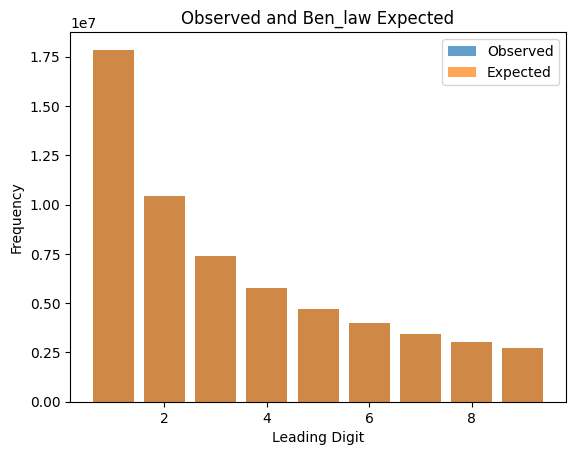

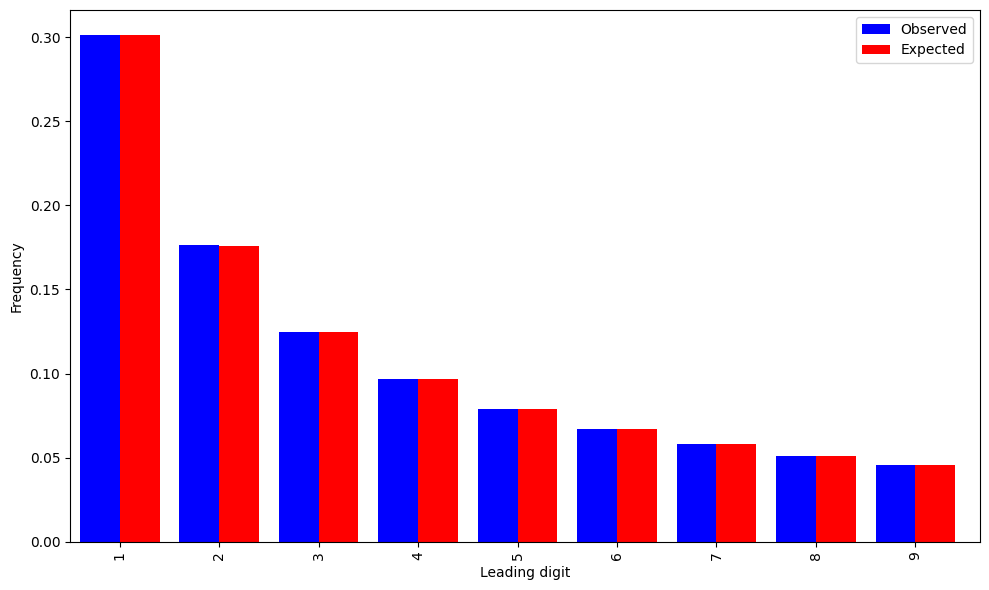

In [8]:
# Perform a chi-square test by using function in library and compared with the calculation we built from the ground
chi2_ben, p_ben = chisquare(list(observed_frequencies.values()), list(expected_frequencies_ben.values()))

# Print the results for Benford's Law
print(f"Chi-square statistic for Benford's Law expected frequency: {chi2_ben}")
print(f"P-value for Benford's Law expected frequency: {p_ben}")

# Create a bar plot for Benford's Law
plt.title('Observed and Ben_law Expected')
plt.bar(range(1, 10), [observed_frequencies[i] for i in range(1, 10)], alpha=0.7, label='Observed')
plt.bar(range(1, 10), [expected_frequencies_ben[i] for i in range(1, 10)], alpha=0.7, label='Expected')
plt.xlabel('Leading Digit')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Convert the frequencies to ratios
observed_ratios = {k: v / total_count for k, v in observed_frequencies.items()}

# Calculate expected frequencies according to Benford's law
expected_frequencies = {i: math.log10(1 + 1 / i) for i in range(1, 10)}

# Create a dataframe from the observed and expected ratios
df = pd.DataFrame({'observed': observed_ratios, 'expected': expected_frequencies})

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
df['observed'].plot(kind='bar', color='blue', ax=ax, width=0.4, position=1, label='Observed')
df['expected'].plot(kind='bar', color='red', ax=ax, width=0.4, position=0, label='Expected')

ax.set_xlabel('Leading digit')
ax.set_ylabel('Frequency')
ax.set_xlim(left=-0.5)  
plt.tight_layout() 
plt.legend()
plt.show()

#### Z-statistic

Z-statistic for 1: -0.9029018740399989
Z-statistic for 2: 2.818499094678338
Z-statistic for 3: -0.5166711509181305
Z-statistic for 4: -0.3677592031165393
Z-statistic for 5: -0.4583229864552251
Z-statistic for 6: -0.30484351204487736
Z-statistic for 7: -0.38383858810191485
Z-statistic for 8: -0.26422305933942647
Z-statistic for 9: -0.15261201689295242


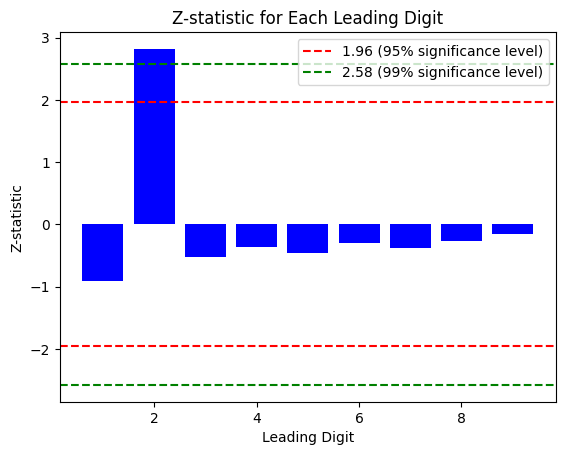

In [9]:
# Calculate the Z-statistic (standard deviations) for each leading digit
z_statistics = [(observed_ratios[i] - expected_frequencies[i]) / 
                np.sqrt(expected_frequencies[i] * (1 - expected_frequencies[i]) / total_count) 
                for i in range(1, 10)]

for i, z in enumerate(z_statistics, start=1):
    print(f"Z-statistic for {i}: {z}")

# visulised the z-statistic
plt.bar(range(1,10), z_statistics, color='blue')
plt.axhline(y=1.96, color='r', linestyle='--', label='1.96 (95% significance level)')
plt.axhline(y=-1.96, color='r', linestyle='--')
plt.axhline(y=2.58, color='g', linestyle='--', label='2.58 (99% significance level)')
plt.axhline(y=-2.58, color='g', linestyle='--')
plt.xlabel('Leading Digit')
plt.ylabel('Z-statistic')
plt.title('Z-statistic for Each Leading Digit')
plt.legend()
plt.show()